<a href="https://colab.research.google.com/github/kresnaj/machinelearning-endproject-dicodingcourse/blob/google-colab/%5BKlasifikasi%5D_Submission_Akhir_BMLP_Joshua%20Kresna%20Kusmono.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Import Library**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, learning_curve

# **2. Memuat Dataset dari Hasil Clustering**

In [2]:
df = pd.read_csv('YoutubeCommentDataset.csv')

# **3. Data Splitting**

Menginisialisasi TfidfVectorizer untuk mengubah dari kategorikal menjadi nilai numerik.

In [3]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Comment'])

In [4]:
X = df['Comment']
y = df['Sentiment']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print("Data yang ditraining:", len(X_train), "\nData yang ditest:", len(X_test))

Data yang ditraining: 14296 
Data yang ditest: 3575


# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

In [6]:
SVC_model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC())
])

RandomForest_model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

SVC_model.fit(X_train, y_train)
RandomForest_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('rf', RandomForestClassifier())])

Saya menggunakan dua model sebagai pembanding nantinya. Untuk model yang saya pakai yaitu pertama SVC dan kedua Random Forest. Karena dalam dataset terdapat tiga sentimen user negative, neutral, dan positive, maka menurut saya dua model ini cocok untuk kebutuhan klasifikasi sentimen user terhadap youtube. Pada Dataset menggunakan tipe data objek, yang mana scikit-learn terutama di bagian Klasifikasi hanya bisa menerima nilai numeric. Maka saya menggunakan tfidfVectorized (menjadikan numeric berdasarkan kepentingan kata seperti suka/tidak suka), karena target saya adalah mengelompokkan sentimen user terhadap youtube.

## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.

In [7]:
predict_with_SVC = SVC_model.predict(X_test)
predict_with_FR = RandomForest_model.predict(X_test)

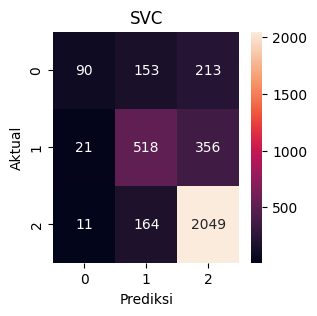

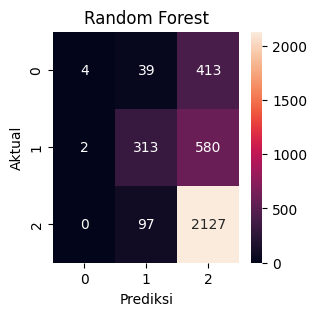

In [11]:
def evaluate_score(model, X_test, y_test, model_name):
  y_pred = model.predict(X_test)
  conix = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(3,3))
  sb.heatmap(conix, annot=True, fmt='d')
  plt.title(model_name)
  plt.ylabel('Aktual')
  plt.xlabel('Prediksi')
  plt.show()
  results = {
      'Confusion Matrix': conix,
      'Accuracy': accuracy_score(y_test, y_pred),
      'Precision': precision_score(y_test, y_pred, average='weighted'),
      'Recall': recall_score(y_test, y_pred, average='weighted'),
      'F1 Score': f1_score(y_test, y_pred, average='weighted')
  }
  return results

model_selection = {
    'SVC': evaluate_score(SVC_model, X_test, y_test, 'SVC'),
    'Random Forest': evaluate_score(RandomForest_model, X_test, y_test, 'Random Forest')
}

Untuk hasil Skoring

In [12]:
summary_score_df = pd.DataFrame(columns=['Model', 'Akurasi', 'Presisi', 'Recall', 'Skor_F1'])

rows = []
for model_name, metrics in model_selection.items():
  rows.append({
      'Model': model_name,
      'Akurasi': metrics['Accuracy'],
      'Presisi': metrics['Precision'],
      'Recall': metrics['Recall'],
      'Skor_F1': metrics['F1 Score']
  })

summary_score_df = pd.DataFrame(rows)
print(summary_score_df)

           Model   Akurasi   Presisi    Recall   Skor_F1
0            SVC  0.743217  0.736293  0.743217  0.716152
1  Random Forest  0.683636  0.683658  0.683636  0.614025


Dari hasil ini, setelah dua model ini melakukan prediksi. Terlihat bahwa Model SVC dengan Akurasi 74%, Presisi 73%, Recall 74% dan Skor F1 71%. Sedangkan Random Forest sedikit di bawah SVC yaitu Akurasi 68%, Presisi 70%, Recall 68%, dan Skor F1 61%. Dari Heatmap ini terlihat pada bagian model SVC, terdapat 90 Komentar negatif dari 456 yang diprediksi benar, 518 Komentar netral dari 895 yang diprediksi benar, dan 2156 Komentar positif dari 2224 diprediksi benar. Sedangkan Random Forest hanya 8 komentar negatif diprediksi benar, 319 komentar netral diprediksi benar, dan 2126 komentar positif diprediksi benar. Dengan kesimpulan bahwa SVC buruk dalam menangkap komentar negatif saja, sedangkan Random Forest buruk pada bagian komentar negatif dan komentar netral.

## **c. Tuning Model Klasifikasi (Optional)**

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

In [14]:
parameter_randomized_svc = {
    'svc__C': [0.1, 1, 10, 50],
    'svc__kernel': ['linear'],
    'svc__gamma': ['scale', 'auto']
}

parameter_randomized_rf = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [5, 10, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

random_search_svc = RandomizedSearchCV(SVC_model, parameter_randomized_svc, n_iter=10, cv=3, scoring='accuracy', n_jobs=2, verbose=1)
random_search_rf = RandomizedSearchCV(RandomForest_model, parameter_randomized_rf, cv=5, n_iter=20, scoring='accuracy', n_jobs=2, verbose=1)

random_search_svc.fit(X_train, y_train)
random_search_rf.fit(X_train, y_train)

print("\n\n")
print("Hasil parameter terbaik SVC:", random_search_svc.best_params_)
print("Skor terbaik SVC:", random_search_svc.best_score_)
print("Hasil parameter terbaik Random Forest:", random_search_rf.best_params_)
print("Skor terbaik Random Forest:", random_search_rf.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits



Hasil parameter terbaik SVC: {'svc__kernel': 'linear', 'svc__gamma': 'scale', 'svc__C': 1}
Skor terbaik SVC: 0.7465718831228019
Hasil parameter terbaik Random Forest: {'rf__n_estimators': 100, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_depth': None}
Skor terbaik Random Forest: 0.6734744409141051


## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.

In [13]:
svc_tuned = random_search_svc.best_estimator_
rf_tuned = random_search_rf.best_estimator_

y_pred_svc = svc_tuned.predict(X_test)
y_pred_rf = rf_tuned.predict(X_test)

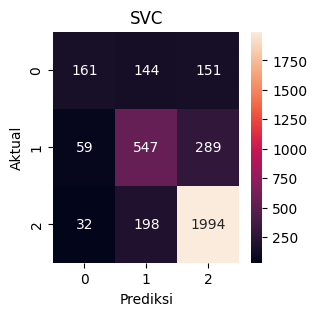

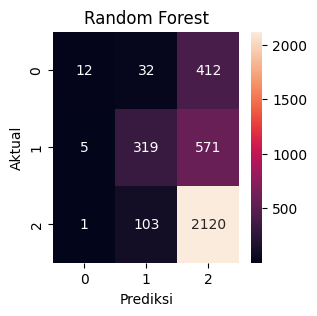

In [16]:
def evaluate_score_tuning(model, X_train, y_train, X_test, y_test, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    conix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(3,3))
    sb.heatmap(conix, annot=True, fmt='d')
    plt.title(model_name)
    plt.ylabel('Aktual')
    plt.xlabel('Prediksi')
    plt.show()
    results = {
        'Confusion Matrix': conix,
        'Akurasi Latihan': train_accuracy,
        'Akurasi Tes': test_accuracy,
        'Overfitting Gap': train_accuracy - test_accuracy,
        'Presisi': precision_score(y_test, y_test_pred, average='weighted'),
        'Recall': recall_score(y_test, y_test_pred, average='weighted'),
        'Skor F1': f1_score(y_test, y_test_pred, average='weighted')
    }
    return results

model_selection = {
    'SVC': evaluate_score_tuning(svc_tuned, X_train, y_train, X_test, y_test, 'SVC'),
    'Random Forest': evaluate_score_tuning(rf_tuned, X_train, y_train, X_test, y_test, 'Random Forest')
}

Scoring Model

In [17]:
summary_score_df = pd.DataFrame(columns=['Model', 'Akurasi Latihan', 'Akurasi Tes', 'Overfitting Gap', 'Presisi', 'Recall', 'Skor F1'])

rows = []
for model_name, metrics in model_selection.items():
    rows.append({
        'Model': model_name,
        'Akurasi Latihan': metrics['Akurasi Latihan'],
        'Akurasi Tes': metrics['Akurasi Tes'],
        'Overfitting Gap': metrics['Overfitting Gap'],
        'Presisi': metrics['Presisi'],
        'Recall': metrics['Recall'],
        'Skor F1': metrics['Skor F1']
    })

summary_score_df = pd.DataFrame(rows)
print(summary_score_df)

           Model  Akurasi Latihan  Akurasi Tes  Overfitting Gap   Presisi  \
0            SVC         0.922286     0.755804         0.166482  0.745171   
1  Random Forest         0.992445     0.685594         0.306851  0.685965   

     Recall   Skor F1  
0  0.755804  0.744149  
1  0.685594  0.620015  


## **e. Analisis Hasil Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Tuning pada model SVC dan Random Forest menggunakan RandomizedCV agar proses lebih cepat dan efisien.
2. - Dari hasil, membuktikan bahwa dua model mengalami peningkatan (SVC) dan (Random Forest). Untuk SVC model sebelum dituning memiliki akurasi 74% dan skor F1 71%, setelah di tuning mengalami peningkatan dengan akurasi 75% dan skor F1 74%. Sedangkan untuk Random Forest Akurasi tetap sama tetapi Skor F1 mengalami peningkatan menjadi 68%. Ini menandakan bahwa Random Forest meiliki konfigurasi yang kurang tepat dalam Tuning.
  - Pada model SVC Tuned, terlihat bahwa Overfitting Gap sebesar 0.16 yang berarti Sedikit Overfitting, sedangkan Random Forest mengalami Overfitting sebesar 0.31.
